<a href="https://colab.research.google.com/github/MyNameIsEldar/Movie_Recommender/blob/main/rec_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🎥Movie Recommender
Recommendation System using deep learning

##✔️Introduction

Required to build embeddings for each user and movie using **neural networks methods**. These embeddings will be used to find more relevant film for user.

Solvig this task I will use the DFM. Deep Factorization Machines (DFM) - is a multi-layer neural network to model the user and item latent factors.

DFM can be trained using backpropagation and can handle missing data.

For this task I will use the **full MovieLens 27M dataset**.


##📑Imports

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, roc_auc_score

## 💾Read The Data 

In [ ]:
# Download the data from link
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip ml-latest.zip

--2023-05-09 15:32:01--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  47.1MB/s    in 5.9s    

2023-05-09 15:32:09 (44.5 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]

Archive:  ml-latest.zip
   creating: ml-latest/
  inflating: ml-latest/links.csv     
  inflating: ml-latest/tags.csv      
  inflating: ml-latest/genome-tags.csv  
  inflating: ml-latest/ratings.csv   
  inflating: ml-latest/README.txt    
  inflating: ml-latest/genome-scores.csv  
  inflating: ml-latest/movies.csv    


In [11]:
PATH = '/content/ml-latest/'

In [16]:
ratings = pd.read_csv(PATH+'ratings.csv')
genome_scores = pd.read_csv(PATH+'genome-scores.csv')
genome_tags = pd.read_csv(PATH+'genome-tags.csv')
links = pd.read_csv(PATH+'links.csv')
movies = pd.read_csv(PATH+'movies.csv')
tags = pd.read_csv(PATH+'tags.csv')

In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


##📊EDA

The dataset has :

* tag.csv : that contains tags applied to movies by users
* rating.csv : that contains ratings of movies by users
* movie.csv : that contains movie information
* link.csv : that contains identifiers that can be used to link to other sources
* genome_scores.csv : that contains movie-tag relevance data
* genome_tags.csv : that contains tag descriptions



Ratings data will be enough for embedding task 

In [21]:
ratings.rating.value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

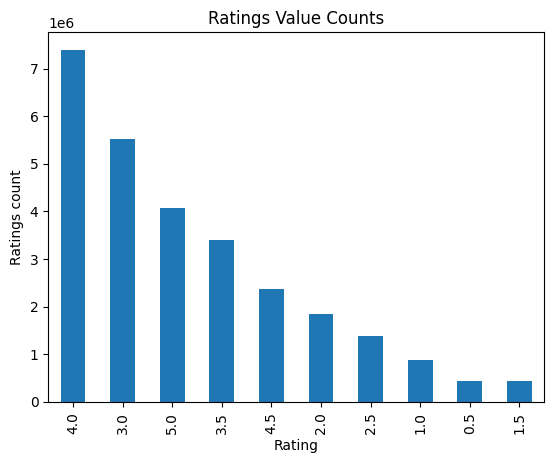

In [29]:
ratings.rating.value_counts().plot(kind='bar')
plt.title('Ratings Value Counts')
plt.ylabel('Ratings count')
plt.xlabel('Rating')
plt.show()

Most frequent rate is 4.0. Rather useres rate movies as 1.0, 0.5 and 1.5

In [27]:
print(f'There are {ratings.movieId.nunique()} unique films in data')

There are 53889 unique films in data


In [28]:
print(f'There are {ratings.userId.nunique()} unique users in data')

There are 283228 unique users in data


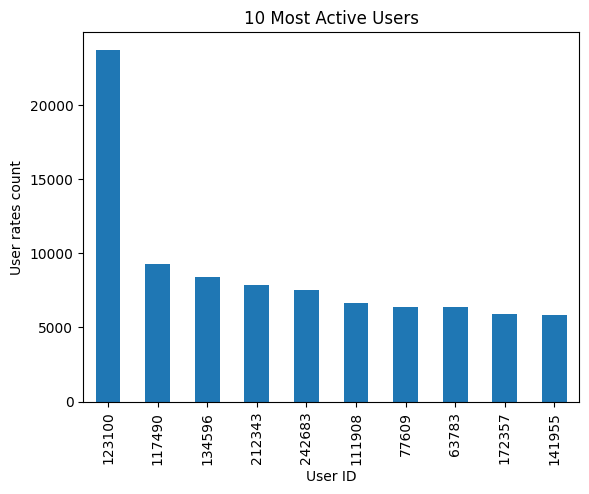

In [30]:
ratings.userId.value_counts()[:10].plot(kind='bar')
plt.title('10 Most Active Users')
plt.ylabel('User rates count')
plt.xlabel('User ID')
plt.show()

One user have more than **20 000** film rates! 

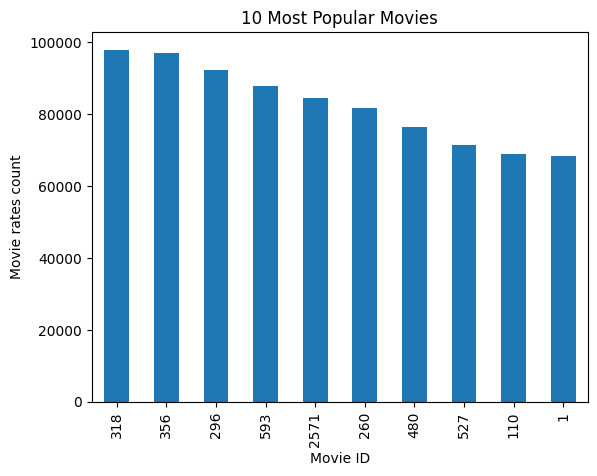

In [31]:
ratings.movieId.value_counts()[:10].plot(kind='bar')
plt.title('10 Most Popular Movies')
plt.ylabel('Movie rates count')
plt.xlabel('Movie ID')
plt.show()

Some of movies has about **100 000 rates**